### Installation
This notebook requires the MIT Uncertainty Quantification library (MUQ), which can be installed via conda from conda-forge:
```
conda install -c conda-forge muq
```
Note that to avoid build conflicts it's useful to create a new conda environment for MUQ:
```
conda create --name muq-env
conda activate muq-env
conda install -c conda-forge muq matplotlib numpy jupyterlab
```

### Useful References
- Cotter et al. (2013) "MCMC Methods for Functions: Modifying Old Algorithms to Make Them Faster"
- Hairer et al. (2014) "Spectral Gaps for a Metropolis-Hastings Algorithm in Infinite Dimensions"
- Roberts and Rosenthal (2001) "Optimal Scaling for Various Metropolis–Hastings Algorithms"

### Imports

In [1]:
import muq.Modeling as mm
import muq.Approximation as ma
import muq.SamplingAlgorithms as ms

import matplotlib.pyplot as plt
import numpy as np

# Spatial Refinement
In this notebook, we consider the problem of using MCMC to sample functions defined on the spatial domain $\Omega=[0,1]$.   We assume the functions lie in a Hilbert space $H$ and are distributed according to a zero mean Gaussian process with covariance kernel $K$, i.e., we consider $f\sim GP(0,K)$. 

To enable computation, we discretize the problem and consider the vector $f_N \in \mathbb{R}^N$, which contains the value of the function $f$ at $N$ evenly spaced points in $[0,1]$.  The following cells draws samples of $f_N$ for several values of $N$.   Notice that for large values of $N$, the samples seem to exhibit the same structure; the discrete approximation $f_N$ is a good approximation to the true function $f$.

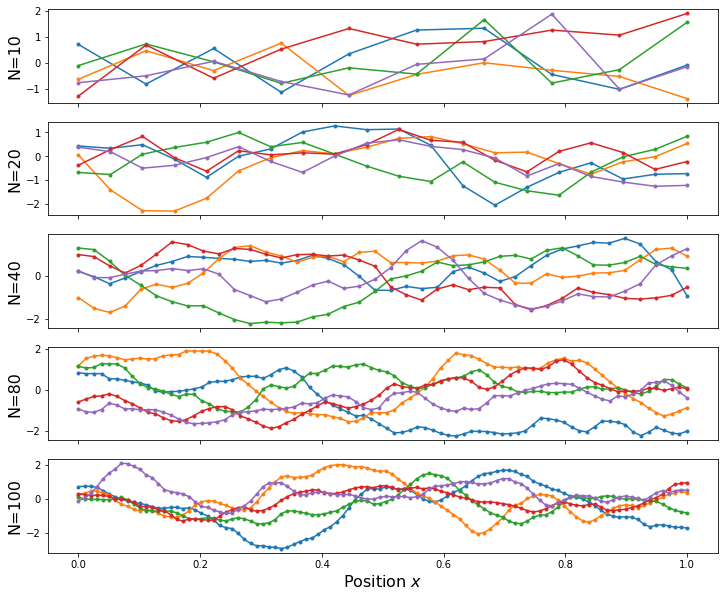

In [2]:
Ns = [10,20,40,80,100]
numSamps = 5

kern = ma.MaternKernel(1,1.0,0.1,3.0/2.0)
mean = ma.ZeroMean(1,1)

fig,axs = plt.subplots(nrows=len(Ns),sharex=True, figsize=(12,10))

for i in range(len(Ns)):
    xs = np.linspace(0,1,Ns[i]).reshape(1,-1)
    dist = ma.GaussianProcess(mean,kern).Discretize(xs)
    
    for k in range(numSamps):
        samp = dist.Sample()
        axs[i].plot(xs[0,:],samp,'.-')
    axs[i].set_ylabel("N={}".format(Ns[i]),fontsize=16)

axs[-1].set_xlabel("Position $x$",fontsize=16)
    
plt.show()

# Target Density

In [46]:
N = 100

xs = np.linspace(0,1,N).reshape(1,-1)
tgtDist = ma.GaussianProcess(mean,kern).Discretize(xs)

# Random Walk Metropolis

The random walk Metropolis algorithm defines the proposed point $f^\prime$ via

$$
f^\prime = f_k + \tau z
$$

where $z\sim N(0,\Sigma_z)$ is a zero mean Gaussian random variable with covariance $\Sigma_w$ and $\tau$ is an algorithmic parameter.    For Gaussian target distributions, optimal values of $\tau$ can be found in [Roberts and Rosenthal (2001)] for optimal scaling results used below.

In [47]:
optScale = (2.38**2)/N # <- Optimal value from Roberts and Rosenthal
propCov = optScale * tgtDist.GetCovariance()
propDist = mm.Gaussian(np.zeros(N),propCov)

In [48]:
opts = dict()
opts['NumSamples'] = 8000 # Number of MCMC steps to take
opts['BurnIn'] = 0 # Number of steps to throw away as burn in
opts['PrintLevel'] = 3 # in {0,1,2,3} Verbosity of the output

In [49]:
problem = ms.SamplingProblem(tgtDist.AsDensity())

# Construct the RWM proposal
rwmProp = ms.MHProposal(opts, problem, propDist)

# Use the proposal to construct a Metropolis-Hastings kernel
transKern = ms.MHKernel(opts,problem,rwmProp)

# Construct the MCMC sampler using this transition kernel
sampler = ms.SingleChainMCMC(opts, [transKern])

In [50]:
x0 = [tgtDist.Sample()]
samps = sampler.Run(x0)

Starting single chain MCMC sampler...
  10% Complete
    Block 0:
      Acceptance Rate = 20%
  20% Complete
    Block 0:
      Acceptance Rate = 23%
  30% Complete
    Block 0:
      Acceptance Rate = 23%
  40% Complete
    Block 0:
      Acceptance Rate = 23%
  50% Complete
    Block 0:
      Acceptance Rate = 23%
  60% Complete
    Block 0:
      Acceptance Rate = 23%
  70% Complete
    Block 0:
      Acceptance Rate = 23%
  80% Complete
    Block 0:
      Acceptance Rate = 23%
  90% Complete
    Block 0:
      Acceptance Rate = 23%
  100% Complete
    Block 0:
      Acceptance Rate = 23%
Completed in 0.45644 seconds.


### Plot the trace of the RWM chain

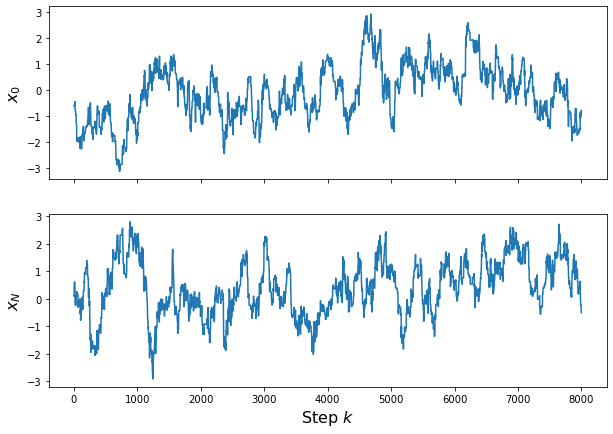

In [51]:
fig, axs = plt.subplots(nrows=2, sharex=True, figsize=(10,7))
axs[0].plot(samps.AsMatrix()[0,:])
axs[1].plot(samps.AsMatrix()[-1,:])

axs[0].set_ylabel('$x_0$', fontsize=16)
axs[1].set_ylabel('$x_N$', fontsize=16)
axs[1].set_xlabel('Step $k$', fontsize=16)
plt.show()

### Compute the RWM Effective Sample Size (ESS)

In [52]:
ess = samps.ESS()
print('Minimum ESS = {:4.0f}'.format(np.min(ess)))

Minimum ESS =   12


# Preconditioned Crank-Nicolson (pCN)

For a zero mean target distribution, the preconditiond Crank-Nicolson proposal defines the proposed point $x^\prime$ via

$$
f^\prime = (1-\beta^2)^{1/2} f_k + \beta w,
$$

where $w\sim N(0,C)$ is a zero mean random variable with a covariance $C$ equal to the prior covariance on $f_N$.



In [53]:
opts['Beta'] = 0.25 # Crank Nicholson parameter
pcnProp = ms.CrankNicolsonProposal(opts, problem, tgtDist)

# Use the proposal to construct a Metropolis-Hastings kernel
transKern = ms.MHKernel(opts,problem,pcnProp)

# Construct the MCMC sampler using this transition kernel
sampler = ms.SingleChainMCMC(opts, [transKern])

In [54]:
x0 = [tgtDist.Sample()]
samps = sampler.Run(x0)

Starting single chain MCMC sampler...
  10% Complete
    Block 0:
      Acceptance Rate = 1e+02%
  20% Complete
    Block 0:
      Acceptance Rate = 1e+02%
  30% Complete
    Block 0:
      Acceptance Rate = 1e+02%
  40% Complete
    Block 0:
      Acceptance Rate = 1e+02%
  50% Complete
    Block 0:
      Acceptance Rate = 1e+02%
  60% Complete
    Block 0:
      Acceptance Rate = 1e+02%
  70% Complete
    Block 0:
      Acceptance Rate = 1e+02%
  80% Complete
    Block 0:
      Acceptance Rate = 1e+02%
  90% Complete
    Block 0:
      Acceptance Rate = 1e+02%
  100% Complete
    Block 0:
      Acceptance Rate = 1e+02%
Completed in 0.447823 seconds.


### Plot the trace of the pCN chain

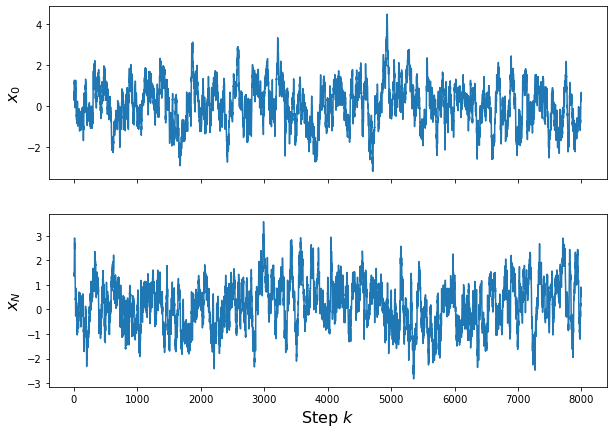

In [55]:
fig, axs = plt.subplots(nrows=2, sharex=True, figsize=(10,7))
axs[0].plot(samps.AsMatrix()[0,:])
axs[1].plot(samps.AsMatrix()[-1,:])

axs[0].set_ylabel('$x_0$', fontsize=16)
axs[1].set_ylabel('$x_N$', fontsize=16)
axs[1].set_xlabel('Step $k$', fontsize=16)
plt.show()

In [56]:
ess = samps.ESS()
print('Minimum ESS = {:4.0f}'.format(np.min(ess)))

Minimum ESS =  110


# Discussion

- How does the performance of the RWM proposal change with the problem dimension $N$?
- How does the performance of pCN proposal change with problem dimension?